In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint



In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Define the base directory
base_dir = "data"  # Pas de "/" au début pour un chemin relatif
  # Replace with your actual data directory

# Define the data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load all data without splitting
all_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Changer ici pour multi-classes
    shuffle=False
)


Found 10155 images belonging to 3 classes.


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

# Extract data and labels from the generator
X = []
y = []
for i in range(len(all_generator)):
    X_batch, y_batch = all_generator[i]
    X.append(X_batch)
    y.append(y_batch)
    if i >= len(all_generator) - 1:  # Avoid infinite loop
        break

X = np.vstack(X)
y = np.concatenate(y, axis=0)  # Use np.concatenate instead of np.hstack to avoid shape issues

# Split the data into training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation (33.33%) and test (66.67%)
# This will result in 10% validation and 20% test of the original data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6667, random_state=42)

# Now you have:
# X_train, y_train for training (70%)
# X_val, y_val for validation (10%)
# X_test, y_test for testing (20%)

# Create generators for training, validation, and test sets
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
validation_generator = datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Verify the splits
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 7108
Validation set size: 1015
Test set size: 2032


Found 0 images belonging to 1 classes.


Found 0 images belonging to 1 classes.


In [4]:
# Load the MobileNet model pre-trained on ImageNet, excluding the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

C:\Users\21652\AppData\Local\Temp\ipykernel_98688\511909134.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


In [5]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce spatial dimensions
x = Dense(1024, activation='relu')(x) 
x =  Dense(512, activation='relu')(x)   # Deuxième couche fully connected
x = Dense(256, activation='relu')(x)  # Troisième couche fully connected
x = Dense(128, activation='relu')(x)  # Quatrième couche fully connected
x = Dropout(0.5)(x)
# Modifier la dernière couche pour 3 classes
predictions = Dense(3, activation='softmax')(x)  


# Combine the base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Modifier la fonction de perte
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',  
              metrics=['accuracy'])


In [8]:
# Train the model
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // train_generator.batch_size,  # Calculate steps manually
    validation_data=validation_generator,
    validation_steps=len(X_val) // validation_generator.batch_size,  # Calculate steps manually
    epochs=100,  # Adjust the number of epochs
    verbose=1,
    callbacks=[checkpoint]  # Ajout du callback ici
)

Epoch 1/100


c:\Users\21652\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3751 - loss: 1.0963
Epoch 1: val_loss improved from inf to 1.09438, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 69s 293ms/step - accuracy: 0.3751 - loss: 1.0963 - val_accuracy: 0.3841 - val_loss: 1.0944
Epoch 2/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - accuracy: 0.3438 - loss: 1.1036

c:\Users\21652\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.09438
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.3438 - loss: 1.1036 - val_accuracy: 0.3841 - val_loss: 1.0945
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.3861 - loss: 1.0921
Epoch 3: val_loss improved from 1.09438 to 1.08551, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 65s 291ms/step - accuracy: 0.3861 - loss: 1.0921 - val_accuracy: 0.3841 - val_loss: 1.0855
Epoch 4/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 53s 240ms/step - accuracy: 0.3750 - loss: 1.0923
Epoch 4: val_loss improved from 1.08551 to 1.08547, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.3750 - loss: 1.0923 - val_accuracy: 0.3841 - val_loss: 1.0855
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3952 - loss: 1.0872
Epoch 5: val_loss improved from 1.08547 to 1.07299, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 63s 286ms/step - accuracy: 0.3953 - loss: 1.0871 - val_accuracy: 0.5111 - val_loss: 1.0730
Epoch 6/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.6562 - loss: 1.0418
Epoch 6: val_loss improved from 1.07299 to 1.07280, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6562 - loss: 1.0418 - val_accuracy: 0.5111 - val_loss: 1.0728
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4519 - loss: 1.0654
Epoch 7: val_loss improved from 1.07280 to 1.00186, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 62s 280ms/step - accuracy: 0.4519 - loss: 1.0653 - val_accuracy: 0.5030 - val_loss: 1.0019
Epoch 8/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 45s 204ms/step - accuracy: 0.5000 - loss: 0.9817
Epoch 8: val_loss did not improve from 1.00186
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5000 - loss: 0.9817 - val_accuracy: 0.4849 - val_loss: 1.0141
Epoch 9/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5014 - loss: 1.0108
Epoch 9: val_loss improved from 1.00186 to 0.96036, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 65s 295ms/step - accuracy: 0.5015 - loss: 1.0108 - val_accuracy: 0.5050 - val_loss: 0.9604
Epoch 10/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.5312 - loss: 0.9629
Epoch 10: val_loss did not improve from 0.96036
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5312 - loss: 0.9629 - val_accuracy: 0.4929 - val_loss: 0.9675
Epoch 11/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5456 - loss: 0.9630
Epoch 11: val_loss improved from 0.96036 to 0.89817, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 69s 309ms/step - accuracy: 0.5456 - loss: 0.9630 - val_accuracy: 0.6079 - val_loss: 0.8982
Epoch 12/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 51s 235ms/step - accuracy: 0.7188 - loss: 0.8132
Epoch 12: val_loss did not improve from 0.89817
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7188 - loss: 0.8132 - val_accuracy: 0.6028 - val_loss: 0.9029
Epoch 13/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5635 - loss: 0.9298
Epoch 13: val_loss did not improve from 0.89817
222/222 ━━━━━━━━━━━━━━━━━━━━ 66s 298ms/step - accuracy: 0.5635 - loss: 0.9298 - val_accuracy: 0.5645 - val_loss: 0.9290
Epoch 14/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:02 283ms/step - accuracy: 0.5625 - loss: 0.9737
Epoch 14: val_loss did not improve from 0.89817
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5625 - loss: 0.9737 - val_accuracy: 0.5766 - val_loss: 0.9018
Epoch 15/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5766 - loss: 0.9207
Epoch 15: val_los

222/222 ━━━━━━━━━━━━━━━━━━━━ 65s 293ms/step - accuracy: 0.5767 - loss: 0.9206 - val_accuracy: 0.6149 - val_loss: 0.8576
Epoch 16/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.4375 - loss: 1.0474
Epoch 16: val_loss improved from 0.85758 to 0.85705, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4375 - loss: 1.0474 - val_accuracy: 0.6149 - val_loss: 0.8571
Epoch 17/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5815 - loss: 0.9112
Epoch 17: val_loss improved from 0.85705 to 0.84355, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 71s 320ms/step - accuracy: 0.5815 - loss: 0.9111 - val_accuracy: 0.6240 - val_loss: 0.8435
Epoch 18/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.7812 - loss: 0.7541
Epoch 18: val_loss improved from 0.84355 to 0.84298, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7812 - loss: 0.7541 - val_accuracy: 0.6250 - val_loss: 0.8430
Epoch 19/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6079 - loss: 0.8730
Epoch 19: val_loss did not improve from 0.84298
222/222 ━━━━━━━━━━━━━━━━━━━━ 63s 284ms/step - accuracy: 0.6079 - loss: 0.8730 - val_accuracy: 0.6069 - val_loss: 0.8447
Epoch 20/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 52s 240ms/step - accuracy: 0.4062 - loss: 1.0405
Epoch 20: val_loss did not improve from 0.84298
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4062 - loss: 1.0405 - val_accuracy: 0.6008 - val_loss: 0.8661
Epoch 21/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6181 - loss: 0.8592
Epoch 21: val_loss improved from 0.84298 to 0.81437, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 274ms/step - accuracy: 0.6180 - loss: 0.8592 - val_accuracy: 0.6522 - val_loss: 0.8144
Epoch 22/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 48s 220ms/step - accuracy: 0.7812 - loss: 0.7555
Epoch 22: val_loss did not improve from 0.81437
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7812 - loss: 0.7555 - val_accuracy: 0.6643 - val_loss: 0.8167
Epoch 23/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6335 - loss: 0.8407
Epoch 23: val_loss did not improve from 0.81437
222/222 ━━━━━━━━━━━━━━━━━━━━ 63s 283ms/step - accuracy: 0.6335 - loss: 0.8407 - val_accuracy: 0.6240 - val_loss: 0.8477
Epoch 24/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.5312 - loss: 0.9427
Epoch 24: val_loss did not improve from 0.81437
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5312 - loss: 0.9427 - val_accuracy: 0.6280 - val_loss: 0.8397
Epoch 25/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6369 - loss: 0.8308
Epoch 25: val_loss

222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7500 - loss: 0.7984 - val_accuracy: 0.6452 - val_loss: 0.8088
Epoch 27/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6214 - loss: 0.8571
Epoch 27: val_loss improved from 0.80883 to 0.78496, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 73s 330ms/step - accuracy: 0.6214 - loss: 0.8571 - val_accuracy: 0.6694 - val_loss: 0.7850
Epoch 28/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 45s 205ms/step - accuracy: 0.6562 - loss: 0.8370
Epoch 28: val_loss did not improve from 0.78496
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6562 - loss: 0.8370 - val_accuracy: 0.6623 - val_loss: 0.7880
Epoch 29/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6523 - loss: 0.7957
Epoch 29: val_loss improved from 0.78496 to 0.77538, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 62s 281ms/step - accuracy: 0.6523 - loss: 0.7956 - val_accuracy: 0.6492 - val_loss: 0.7754
Epoch 30/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:02 283ms/step - accuracy: 0.6250 - loss: 0.7994
Epoch 30: val_loss did not improve from 0.77538
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6250 - loss: 0.7994 - val_accuracy: 0.6452 - val_loss: 0.7891
Epoch 31/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6687 - loss: 0.7839
Epoch 31: val_loss improved from 0.77538 to 0.77447, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 71s 320ms/step - accuracy: 0.6687 - loss: 0.7840 - val_accuracy: 0.6633 - val_loss: 0.7745
Epoch 32/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:11 324ms/step - accuracy: 0.7812 - loss: 0.6867
Epoch 32: val_loss improved from 0.77447 to 0.76027, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7812 - loss: 0.6867 - val_accuracy: 0.6694 - val_loss: 0.7603
Epoch 33/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.6616 - loss: 0.7857
Epoch 33: val_loss improved from 0.76027 to 0.75635, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 67s 302ms/step - accuracy: 0.6616 - loss: 0.7857 - val_accuracy: 0.6522 - val_loss: 0.7564
Epoch 34/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:29 406ms/step - accuracy: 0.7812 - loss: 0.7565
Epoch 34: val_loss improved from 0.75635 to 0.75591, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7812 - loss: 0.7565 - val_accuracy: 0.6522 - val_loss: 0.7559
Epoch 35/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6730 - loss: 0.7559
Epoch 35: val_loss did not improve from 0.75591
222/222 ━━━━━━━━━━━━━━━━━━━━ 84s 377ms/step - accuracy: 0.6730 - loss: 0.7559 - val_accuracy: 0.6683 - val_loss: 0.7710
Epoch 36/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:09 314ms/step - accuracy: 0.6250 - loss: 0.7815
Epoch 36: val_loss did not improve from 0.75591
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6250 - loss: 0.7815 - val_accuracy: 0.6653 - val_loss: 0.7614
Epoch 37/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6724 - loss: 0.7710
Epoch 37: val_loss improved from 0.75591 to 0.75393, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 349ms/step - accuracy: 0.6724 - loss: 0.7709 - val_accuracy: 0.6542 - val_loss: 0.7539
Epoch 38/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 57s 260ms/step - accuracy: 0.6250 - loss: 0.8012
Epoch 38: val_loss improved from 0.75393 to 0.74743, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.6250 - loss: 0.8012 - val_accuracy: 0.6673 - val_loss: 0.7474
Epoch 39/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6807 - loss: 0.7412
Epoch 39: val_loss did not improve from 0.74743
222/222 ━━━━━━━━━━━━━━━━━━━━ 70s 317ms/step - accuracy: 0.6807 - loss: 0.7412 - val_accuracy: 0.6683 - val_loss: 0.7724
Epoch 40/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:03 287ms/step - accuracy: 0.6875 - loss: 0.8113
Epoch 40: val_loss did not improve from 0.74743
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6875 - loss: 0.8113 - val_accuracy: 0.6593 - val_loss: 0.7636
Epoch 41/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6798 - loss: 0.7476
Epoch 41: val_loss did not improve from 0.74743
222/222 ━━━━━━━━━━━━━━━━━━━━ 65s 294ms/step - accuracy: 0.6798 - loss: 0.7475 - val_accuracy: 0.6562 - val_loss: 0.8006
Epoch 42/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 59s 269ms/step - accuracy: 0.5938 - loss: 0.9008
Epoch 42: val_lo

222/222 ━━━━━━━━━━━━━━━━━━━━ 78s 353ms/step - accuracy: 0.6704 - loss: 0.7596 - val_accuracy: 0.6683 - val_loss: 0.7193
Epoch 44/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:10 319ms/step - accuracy: 0.7188 - loss: 0.7793
Epoch 44: val_loss improved from 0.71931 to 0.70917, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7188 - loss: 0.7793 - val_accuracy: 0.6784 - val_loss: 0.7092
Epoch 45/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6852 - loss: 0.7305
Epoch 45: val_loss did not improve from 0.70917
222/222 ━━━━━━━━━━━━━━━━━━━━ 62s 279ms/step - accuracy: 0.6852 - loss: 0.7305 - val_accuracy: 0.6694 - val_loss: 0.7154
Epoch 46/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 55s 250ms/step - accuracy: 0.7812 - loss: 0.5456
Epoch 46: val_loss did not improve from 0.70917
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7812 - loss: 0.5456 - val_accuracy: 0.6764 - val_loss: 0.7341
Epoch 47/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7031 - loss: 0.7017
Epoch 47: val_loss improved from 0.70917 to 0.69180, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 72s 323ms/step - accuracy: 0.7030 - loss: 0.7018 - val_accuracy: 0.7036 - val_loss: 0.6918
Epoch 48/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 59s 268ms/step - accuracy: 0.7188 - loss: 0.7068
Epoch 48: val_loss improved from 0.69180 to 0.68749, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7188 - loss: 0.7068 - val_accuracy: 0.6956 - val_loss: 0.6875
Epoch 49/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6998 - loss: 0.6946
Epoch 49: val_loss improved from 0.68749 to 0.68207, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.6998 - loss: 0.6946 - val_accuracy: 0.6915 - val_loss: 0.6821
Epoch 50/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 52s 236ms/step - accuracy: 0.7188 - loss: 0.7076
Epoch 50: val_loss did not improve from 0.68207
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7188 - loss: 0.7076 - val_accuracy: 0.6865 - val_loss: 0.6922
Epoch 51/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7101 - loss: 0.6830
Epoch 51: val_loss did not improve from 0.68207
222/222 ━━━━━━━━━━━━━━━━━━━━ 68s 306ms/step - accuracy: 0.7100 - loss: 0.6830 - val_accuracy: 0.6794 - val_loss: 0.7186
Epoch 52/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 51s 233ms/step - accuracy: 0.8125 - loss: 0.6432
Epoch 52: val_loss did not improve from 0.68207
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8125 - loss: 0.6432 - val_accuracy: 0.6764 - val_loss: 0.7244
Epoch 53/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7071 - loss: 0.6805
Epoch 53: val_loss

222/222 ━━━━━━━━━━━━━━━━━━━━ 62s 281ms/step - accuracy: 0.7250 - loss: 0.6650 - val_accuracy: 0.7056 - val_loss: 0.6682
Epoch 58/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.8125 - loss: 0.5319
Epoch 58: val_loss did not improve from 0.66819
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8125 - loss: 0.5319 - val_accuracy: 0.6845 - val_loss: 0.6845
Epoch 59/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7198 - loss: 0.6615
Epoch 59: val_loss improved from 0.66819 to 0.65779, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 267ms/step - accuracy: 0.7197 - loss: 0.6616 - val_accuracy: 0.7087 - val_loss: 0.6578
Epoch 60/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:01 278ms/step - accuracy: 0.7188 - loss: 0.7009
Epoch 60: val_loss improved from 0.65779 to 0.65680, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7188 - loss: 0.7009 - val_accuracy: 0.7188 - val_loss: 0.6568
Epoch 61/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7301 - loss: 0.6477
Epoch 61: val_loss did not improve from 0.65680
222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 246ms/step - accuracy: 0.7301 - loss: 0.6477 - val_accuracy: 0.7127 - val_loss: 0.6740
Epoch 62/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.7500 - loss: 0.7612
Epoch 62: val_loss did not improve from 0.65680
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7500 - loss: 0.7612 - val_accuracy: 0.6915 - val_loss: 0.6933
Epoch 63/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7216 - loss: 0.6491
Epoch 63: val_loss improved from 0.65680 to 0.61627, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy: 0.7216 - loss: 0.6491 - val_accuracy: 0.7450 - val_loss: 0.6163
Epoch 64/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - accuracy: 0.7812 - loss: 0.7197
Epoch 64: val_loss did not improve from 0.61627
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7812 - loss: 0.7197 - val_accuracy: 0.7399 - val_loss: 0.6231
Epoch 65/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7337 - loss: 0.6427
Epoch 65: val_loss did not improve from 0.61627
222/222 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.7337 - loss: 0.6427 - val_accuracy: 0.7369 - val_loss: 0.6375
Epoch 66/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:06 301ms/step - accuracy: 0.7500 - loss: 0.4729
Epoch 66: val_loss did not improve from 0.61627
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7500 - loss: 0.4729 - val_accuracy: 0.7389 - val_loss: 0.6343
Epoch 67/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7276 - loss: 0.6558
Epoch 67: val_los

222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 276ms/step - accuracy: 0.7301 - loss: 0.6415 - val_accuracy: 0.7661 - val_loss: 0.5942
Epoch 76/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.8750 - loss: 0.5246
Epoch 76: val_loss improved from 0.59419 to 0.59368, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.8750 - loss: 0.5246 - val_accuracy: 0.7702 - val_loss: 0.5937
Epoch 77/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7504 - loss: 0.6004
Epoch 77: val_loss did not improve from 0.59368
222/222 ━━━━━━━━━━━━━━━━━━━━ 60s 272ms/step - accuracy: 0.7503 - loss: 0.6005 - val_accuracy: 0.6593 - val_loss: 0.7560
Epoch 78/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 45s 205ms/step - accuracy: 0.6875 - loss: 0.8875
Epoch 78: val_loss did not improve from 0.59368
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6875 - loss: 0.8875 - val_accuracy: 0.6532 - val_loss: 0.7667
Epoch 79/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7523 - loss: 0.6200
Epoch 79: val_loss did not improve from 0.59368
222/222 ━━━━━━━━━━━━━━━━━━━━ 60s 269ms/step - accuracy: 0.7523 - loss: 0.6199 - val_accuracy: 0.7026 - val_loss: 0.6657
Epoch 80/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 1:00 273ms/step - accuracy: 0.8125 - loss: 0.4930
Epoch 80: val_los

222/222 ━━━━━━━━━━━━━━━━━━━━ 56s 253ms/step - accuracy: 0.7662 - loss: 0.5810 - val_accuracy: 0.7661 - val_loss: 0.5698
Epoch 82/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 42s 194ms/step - accuracy: 0.7812 - loss: 0.4839
Epoch 82: val_loss did not improve from 0.56981
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7812 - loss: 0.4839 - val_accuracy: 0.7621 - val_loss: 0.5767
Epoch 83/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7626 - loss: 0.5838
Epoch 83: val_loss did not improve from 0.56981
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 260ms/step - accuracy: 0.7626 - loss: 0.5838 - val_accuracy: 0.7510 - val_loss: 0.6320
Epoch 84/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 57s 261ms/step - accuracy: 0.6875 - loss: 0.7399
Epoch 84: val_loss did not improve from 0.56981
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6875 - loss: 0.7399 - val_accuracy: 0.7520 - val_loss: 0.6243
Epoch 85/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7658 - loss: 0.5767
Epoch 85: val_loss

222/222 ━━━━━━━━━━━━━━━━━━━━ 54s 245ms/step - accuracy: 0.7766 - loss: 0.5606 - val_accuracy: 0.7661 - val_loss: 0.5589
Epoch 94/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.8438 - loss: 0.4182
Epoch 94: val_loss did not improve from 0.55887
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8438 - loss: 0.4182 - val_accuracy: 0.7651 - val_loss: 0.5624
Epoch 95/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7702 - loss: 0.5656
Epoch 95: val_loss improved from 0.55887 to 0.54538, saving model to best_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 51s 228ms/step - accuracy: 0.7702 - loss: 0.5657 - val_accuracy: 0.7873 - val_loss: 0.5454
Epoch 96/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.8750 - loss: 0.4076
Epoch 96: val_loss did not improve from 0.54538
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8750 - loss: 0.4076 - val_accuracy: 0.7802 - val_loss: 0.5547
Epoch 97/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7839 - loss: 0.5368
Epoch 97: val_loss did not improve from 0.54538
222/222 ━━━━━━━━━━━━━━━━━━━━ 53s 241ms/step - accuracy: 0.7839 - loss: 0.5368 - val_accuracy: 0.7792 - val_loss: 0.5563
Epoch 98/100
  1/222 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.9375 - loss: 0.3078
Epoch 98: val_loss did not improve from 0.54538
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9375 - loss: 0.3078 - val_accuracy: 0.7712 - val_loss: 0.5684
Epoch 99/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7769 - loss: 0.5547
Epoch 99: val_loss

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8750 - loss: 0.4654 - val_accuracy: 0.7762 - val_loss: 0.5392


In [9]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - accuracy: 0.7796 - loss: 0.5459
Test Accuracy: 0.7810


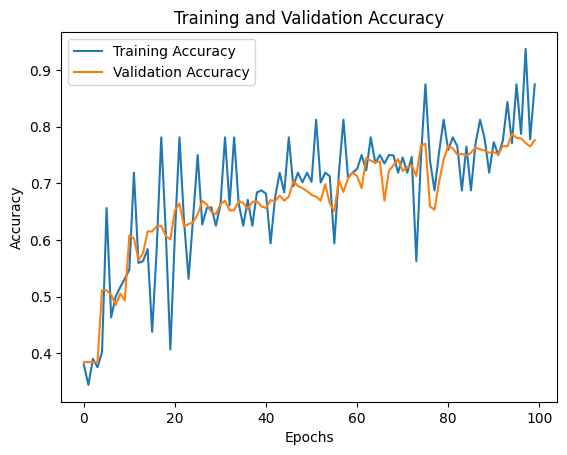

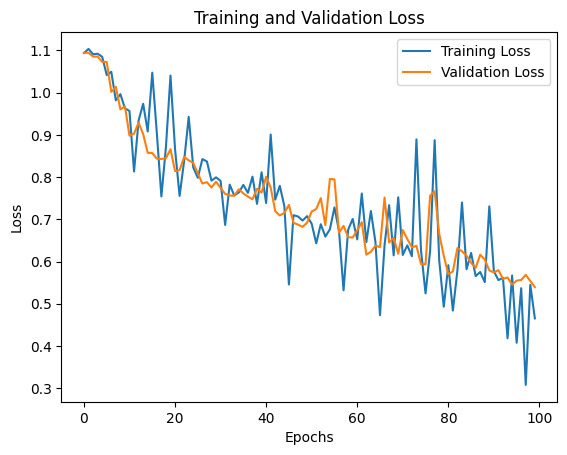

In [10]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save('model3.h5')

In [14]:
import cv2
import numpy as np
import tensorflow as tf

# Charger le modèle pré-entraîné
model = tf.keras.models.load_model('model3.h5')

# Dictionnaire des émotions pour 3 catégories
emotion_labels = ['Fatigue', 'Neutre', 'Tres Fatigue']

# Ouvrir la caméra
cap = cv2.VideoCapture(0)

# Vérifier si la caméra est bien ouverte
if not cap.isOpened():
    print("Erreur : impossible d'ouvrir la caméra.")
    exit()

# Chargement du classificateur de visage OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Variable pour stocker la dernière position du visage détecté
last_face = None

while True:
    ret, frame = cap.read()

    if ret:
        # Convertir en niveaux de gris pour la détection des visages
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Détecter les visages
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        # Si aucun visage n'est détecté, garder le dernier visage connu
        if len(faces) == 0 and last_face is not None:
            faces = [last_face]

        for (x, y, w, h) in faces:
            last_face = (x, y, w, h)  # Sauvegarder la position actuelle

            # Ajouter un padding pour capturer aussi les bras
            padding = int(h * 0.7)  # Ajuste l'extension du cadrage (70% de la hauteur du visage)

            # Définir les nouvelles coordonnées avec padding
            x1, y1 = max(x - padding, 0), max(y - padding, 0)
            x2, y2 = min(x + w + padding, frame.shape[1]), min(y + h + padding, frame.shape[0])

            # Extraire et prétraiter la région d'intérêt (ROI)
            face = frame[y1:y2, x1:x2]  # Garder l'image en couleur
            face = cv2.resize(face, (150, 150))  # Adapter à la taille du modèle (150x150x3)
            face = face.astype('float32') / 255  # Normaliser
            face = np.expand_dims(face, axis=0)  # Ajouter la dimension batch

            # Vérification de la shape
            if face.shape[1:] != (150, 150, 3):
                print(f"Erreur de shape ! Attend : (150, 150, 3) | Reçu : {face.shape[1:]}")
                continue  # Passer au visage suivant en cas d'erreur

            # Prédire l'émotion
            prediction = model.predict(face)
            max_index = np.argmax(prediction[0])  # Trouver l'émotion avec la plus grande probabilité
            emotion = emotion_labels[max_index]  # Associer au label correct

            # Dessiner un rectangle autour de la zone élargie et afficher l'émotion détectée
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Positionner le texte au centre de l'écran
            text_x = frame.shape[1] // 2 - 100
            text_y = 50
            cv2.putText(frame, emotion, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)

        # Afficher l'image avec la prédiction
        cv2.imshow('Détection d\'émotions', frame)

    # Quitter si l'utilisateur appuie sur 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer la caméra et fermer les fenêtres
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━